In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Bidirectional
from keras.callbacks import EarlyStopping
import keras
from matplotlib import style
style.use("seaborn-v0_8-dark")

In [2]:
base_dir = "/kaggle/input/predict-energy-behavior-of-prosumers"

In [3]:
train = pd.read_csv(os.path.join(base_dir, 'train.csv'), parse_dates=True)

In [4]:
# for i in range(0, 15):
#     county = train[train['county']==i]
#     print(f'county{i}: {county.shape[0]}')
# train = train[train['county']==0]
train = train[train['is_consumption']==1]


In [5]:
train = train.groupby(['datetime'])['target'].mean().reset_index()
train.head()

,datetime,target
0,2021-09-01 00:00:00,325.570623
1,2021-09-01 01:00:00,315.820951
2,2021-09-01 02:00:00,315.752328
3,2021-09-01 03:00:00,311.909574
4,2021-09-01 04:00:00,317.493836


In [6]:
train.shape

(15312, 2)

In [7]:
dataset = train
dataset["Month"] = pd.to_datetime(dataset["datetime"]).dt.month
dataset["Year"] = pd.to_datetime(dataset["datetime"]).dt.year
dataset["Date"] = pd.to_datetime(dataset["datetime"]).dt.date
dataset["Time"] = pd.to_datetime(dataset["datetime"]).dt.time
dataset["Week"] = pd.to_datetime(dataset["datetime"]).dt.isocalendar().week
dataset["Day"] = pd.to_datetime(dataset["datetime"]).dt.day_name()
dataset = dataset.set_index("datetime")
dataset.index = pd.to_datetime(dataset.index)

In [8]:
dataset = dataset[121:-72]

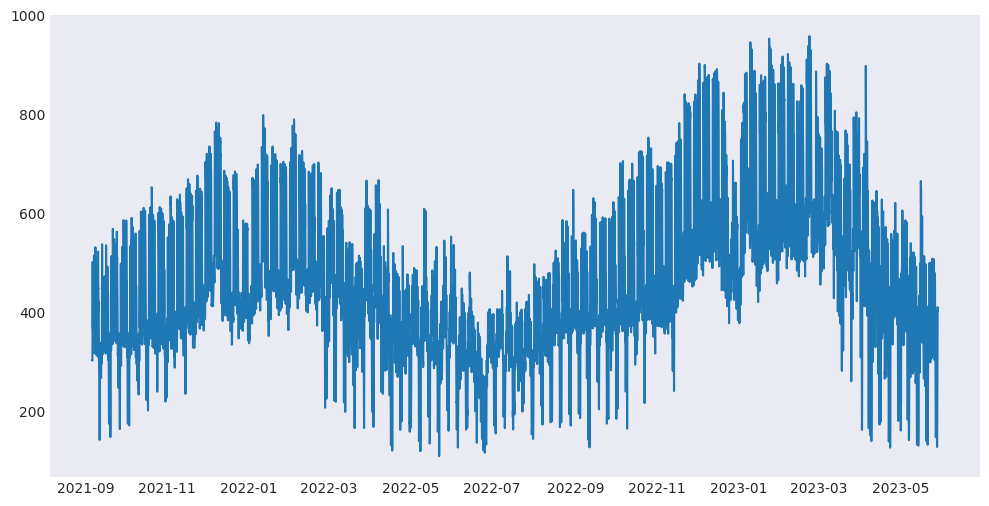

In [9]:
plt.figure(figsize=(12,6))
plt.plot(dataset["target"])

/tmp/ipykernel_42/3821144039.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset["target"])


Text(0.5, 1.0, 'Energy Distribution')

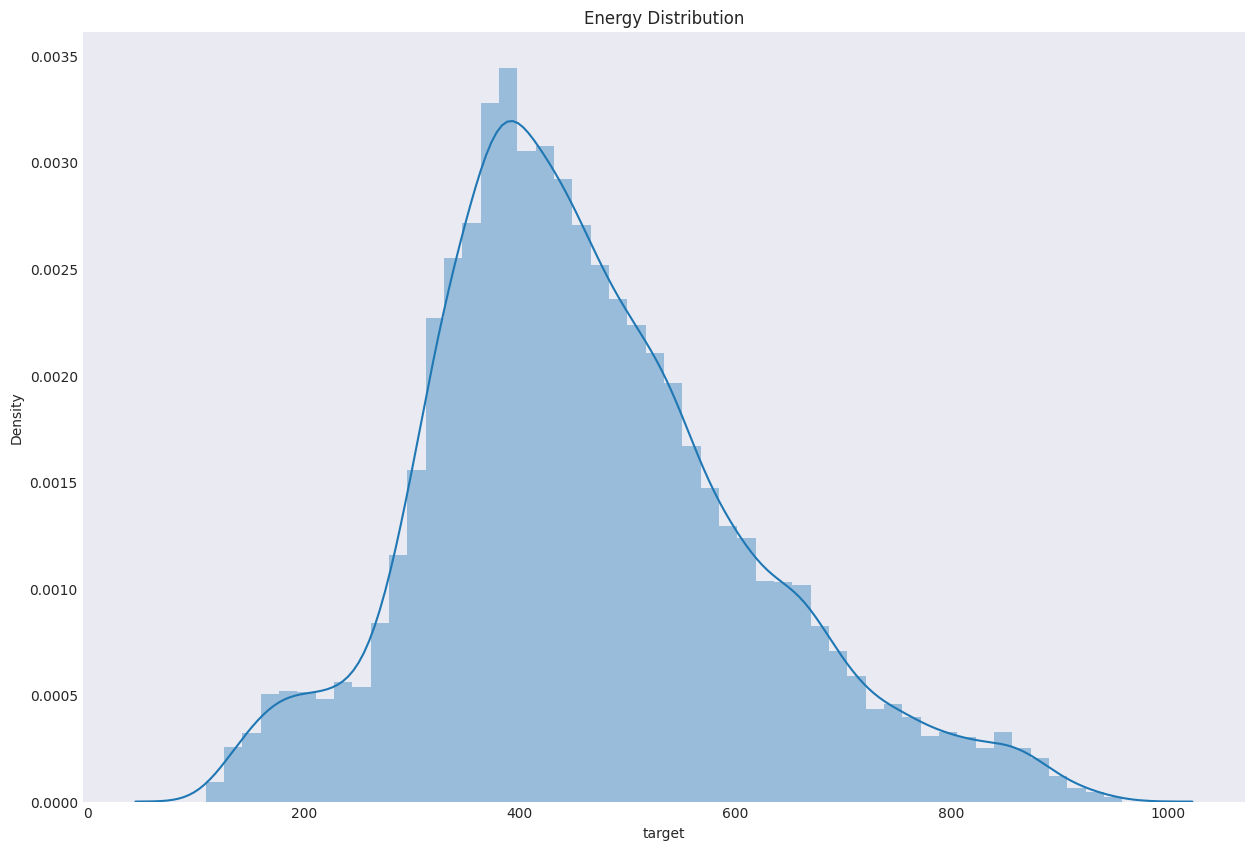

In [10]:

# Lets us see the Distribution off Energy Consumption so we have a idea about your Dataset a bit more
fig = plt.figure(figsize = (15,10))
sns.distplot(dataset["target"])
plt.title("Energy Distribution")

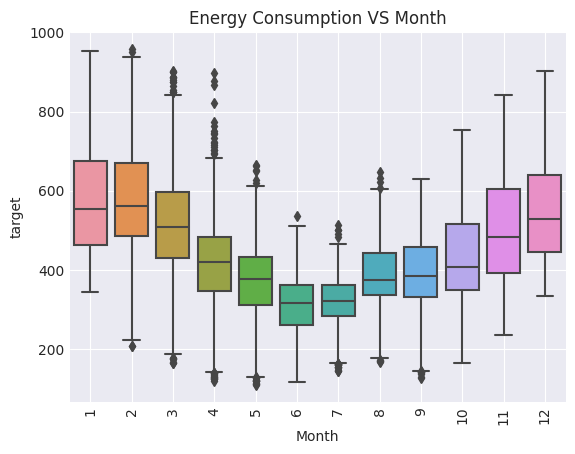

In [11]:
  
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

sns.boxplot(x=dataset["Month"], y=dataset["target"], data= dataset)
plt.title("Energy Consumption VS Month")
plt.xlabel("Month")
plt.grid(True, alpha=1)
plt.legend()

for label in ax1.xaxis.get_ticklabels():
    label.set_rotation(90)

plt.show()

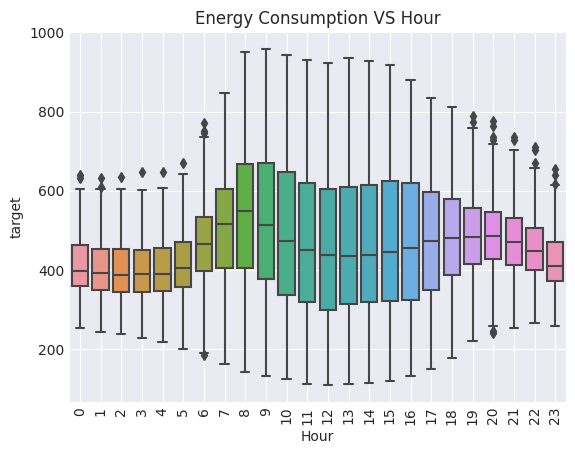

In [12]:
dataset1 = dataset
fig, ax1 = plt.subplots()
sns.boxplot(x=dataset1.index.hour, y=dataset1.target, data= dataset)
plt.title("Energy Consumption VS Hour")
plt.xlabel("Hour")
plt.grid(True, alpha=1)
plt.legend()

for label in ax1.xaxis.get_ticklabels():
    label.set_rotation(90)

In [13]:
# Downsampling involves decreasing the time-frequency of the data
# Downsapling the time-frequency from hours to days 
dataset = dataset.drop(['Time', 'Day', 'Date'], axis=1)
newDataSet = dataset.resample("D").mean()
newDataSet.head()

,target,Month,Year,Week
datetime,,,,
2021-09-06,389.732316,9.0,2021.0,36.0
2021-09-07,394.129101,9.0,2021.0,36.0
2021-09-08,424.580922,9.0,2021.0,36.0
2021-09-09,379.625703,9.0,2021.0,36.0
2021-09-10,404.478858,9.0,2021.0,36.0


In [14]:
y = newDataSet["target"]
print(y[0])
y.shape


389.7323157519601


(630,)

In [15]:
# Normalize data before model fitting
# it will boost the performance( in neural networks) + transform
from sklearn.preprocessing import MinMaxScaler
# scale of the output and input inthe range 0-1 to match the scale of the layer of LSTM
scaler = MinMaxScaler(feature_range = (0,1)) 
# reshape: convert the univariate 1D array into 2D
y = scaler.fit_transform(np.array(y).reshape(-1,1))
print("Normalizing data before model fitting")
print(y[:10])

Normalizing data before model fitting
[[0.34888724]
 [0.35643032]
 [0.40867315]
 [0.33154843]
 [0.37418626]
 [0.11950241]
 [0.17770836]
 [0.34750966]
 [0.31362444]
 [0.34758277]]


In [16]:
training_size = int(len(y)*0.80)
val_size = int(len(y)*0.90)
train_data = y[0:training_size,:]
val_data = y[training_size:val_size,:1]
test_data = y[val_size:,:1]


In [108]:
train_data

,target
datetime,
2021-09-06,389.732316
2021-09-07,394.129101
2021-09-08,424.580922
2021-09-09,379.625703
2021-09-10,404.478858
...,...
2023-03-22,640.010626
2023-03-23,558.690327
2023-03-24,552.181456


In [17]:
# building input variable
def create_dataset(dataset, time_step = 1):
    dataX, dataY = [] , []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step),0]
        dataX.append(a)
        dataY.append(dataset[i + time_step,0])
    return np.array(dataX), np.array(dataY)

In [18]:
time_step = 2
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)
X_val, yval = create_dataset(val_data, time_step)


In [19]:
# reshape train and input-output pairs
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1],1)

print("X_train shape: ", X_train.shape)
print("X_test shape: ",X_test.shape)
print("X_val shape: ",X_val.shape)

X_train shape:  (501, 2, 1)
X_test shape:  (60, 2, 1)
X_val shape:  (60, 2, 1)


In [20]:


model = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (time_step, 1)))
model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
# model.add(Dropout(0.2))

# # Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
# model.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
# model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mse')

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2, 50)             10400     
                                                                 
 dropout (Dropout)           (None, 2, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 2, 50)             20200     
                                                                 
 lstm_2 (LSTM)               (None, 2, 50)             20200     
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 71051 (277.54 KB)
Trainable params: 71051 

In [107]:
X_train

array([[[0.34888724],
        [0.35643032]],

       [[0.35643032],
        [0.40867315]],

       [[0.40867315],
        [0.33154843]],

       ...,

       [[0.85894358],
        [0.83607562]],

       [[0.83607562],
        [0.85653553]],

       [[0.85653553],
        [0.86024316]]])

In [22]:
history = model.fit(X_train, y_train, validation_data = (X_val,yval), verbose = 1,epochs = 60 ,batch_size = 20)


Epoch 1/60
26/26 [==============================] - 8s 58ms/step - loss: 0.1547 - val_loss: 0.1238
Epoch 2/60
26/26 [==============================] - 0s 9ms/step - loss: 0.0344 - val_loss: 0.0687
Epoch 3/60
26/26 [==============================] - 0s 9ms/step - loss: 0.0322 - val_loss: 0.0657
Epoch 4/60
26/26 [==============================] - 0s 10ms/step - loss: 0.0292 - val_loss: 0.0339
Epoch 5/60
26/26 [==============================] - 0s 10ms/step - loss: 0.0249 - val_loss: 0.0323
Epoch 6/60
26/26 [==============================] - 0s 10ms/step - loss: 0.0229 - val_loss: 0.0296
Epoch 7/60
26/26 [==============================] - 0s 9ms/step - loss: 0.0220 - val_loss: 0.0290
Epoch 8/60
26/26 [==============================] - 0s 10ms/step - loss: 0.0221 - val_loss: 0.0276
Epoch 9/60
26/26 [==============================] - 0s 10ms/step - loss: 0.0219 - val_loss: 0.0306
Epoch 10/60
26/26 [==============================] - 0s 10ms/step - loss: 0.0210 - val_loss: 0.0253
Epoch 11/60


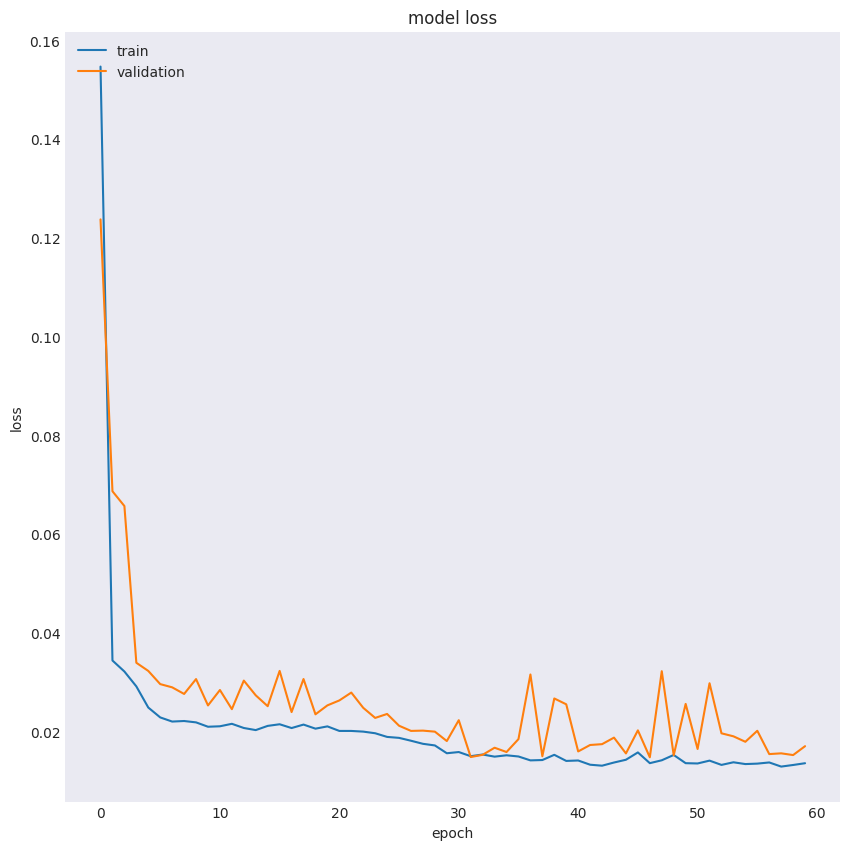

In [23]:
plt.figure(figsize=(10,10))
plt.plot(history.history['loss']) # tb
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [24]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
val_predict=model.predict(X_test)

2/2 [==============================] - 0s 5ms/step


In [25]:
mae = mean_absolute_error(ytest, test_predict)
print('MAE Test Data: '+str(mae))
rmse = np.sqrt(mean_squared_error(ytest, test_predict))
print('RMSE Test Data: '+str(rmse))

mae = mean_absolute_error(y_train, train_predict)
print('MAE Train Data: '+str(mae))
rmse = np.sqrt(mean_squared_error(y_train, train_predict))
print('RMSE Train Data: '+str(rmse))


MAE Test Data: 0.09637927438006776
RMSE Test Data: 0.12352485557104419
MAE Train Data: 0.08401195630399076
RMSE Train Data: 0.11115615018429277


In [26]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)
val_predict=scaler.inverse_transform(val_predict)
     

In [27]:
print(train_predict.shape)
print(test_predict.shape)
print(val_predict.shape)
print(train_predict[0])
print(y_train.shape)


(501, 1)
(60, 1)
(60, 1)
[399.48172]
(501,)


In [28]:
# Predicting consumption using training data
train_predictions = model.predict(X_train)
train_predictions =scaler.inverse_transform(train_predictions)

y_train = y_train.reshape(y_train.shape[0], 1)
actual = scaler.inverse_transform(y_train)
train_results = pd.DataFrame()

train_results["Train Predictions"] = train_predictions.tolist()
train_results["Actuals"] = actual.tolist()

train_results

16/16 [==============================] - 0s 3ms/step


,Train Predictions,Actuals
0,[399.4817199707031],[424.5809221311476]
1,[424.4957580566406],[379.62570286885244]
2,[384.3767395019531],[404.4788579234973]
3,[409.03350830078125],[256.0262233606557]
4,[306.843505859375],[289.9538859289617]
...,...,...
496,[654.8233032226562],[687.0389888059702]
497,[657.1517333984375],[673.7094894278608]
498,[625.2635498046875],[685.6353630050504]
499,[645.8444213867188],[687.7965031565654]


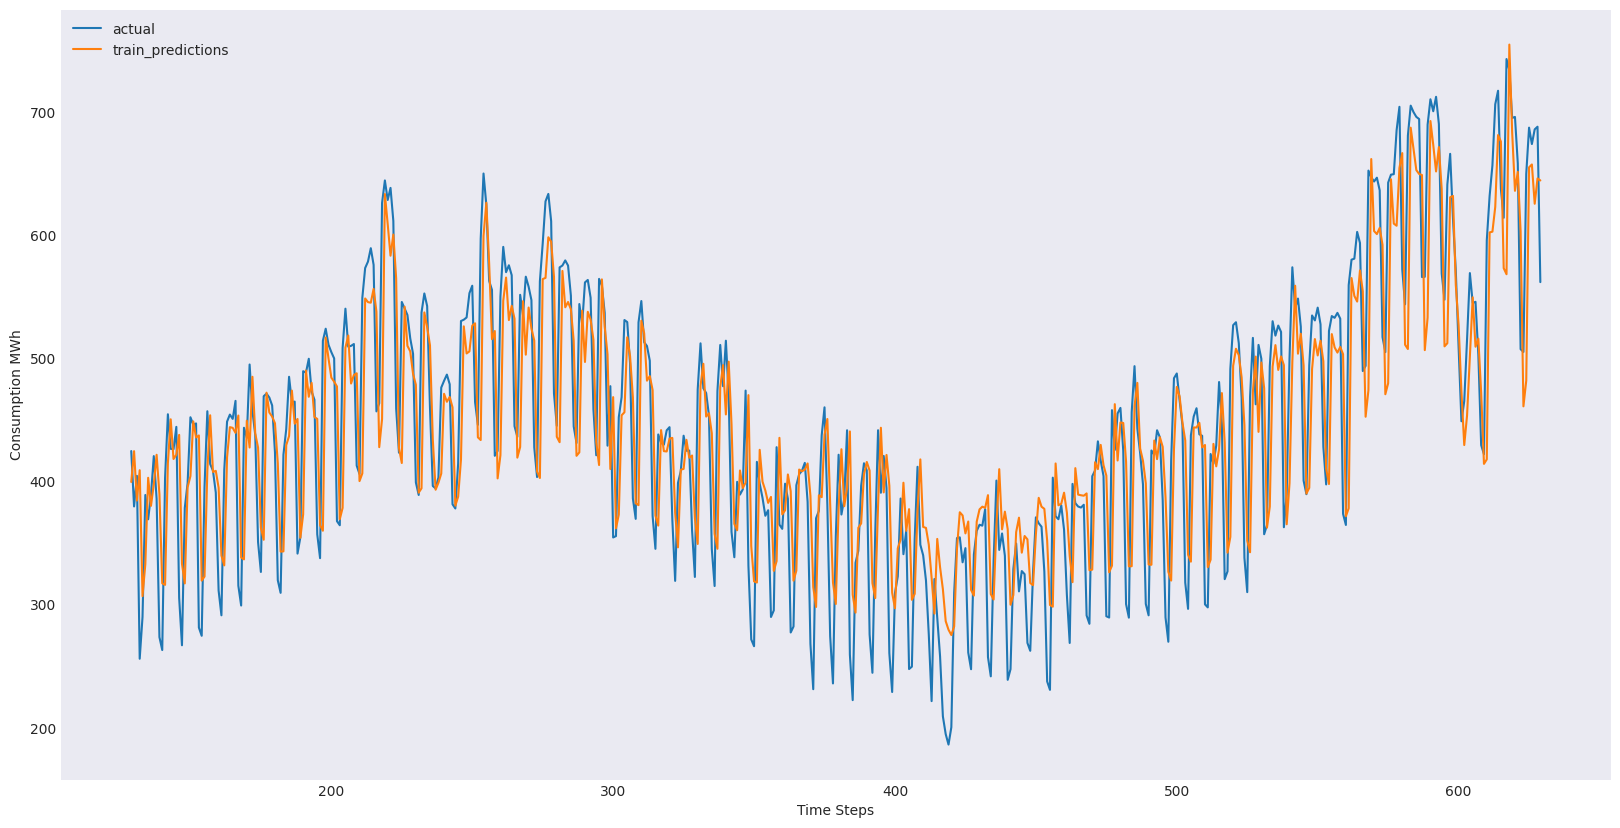

In [29]:
plt.figure(figsize=(20,10))

# Actual Consumption
ActualPlot = np.empty_like(y)
ActualPlot[:, :] = np.nan
ActualPlot[129:, :] = actual.tolist()
plt.plot(ActualPlot)

TrainPredictionsPlot = np.empty_like(y )
TrainPredictionsPlot[:, :] = np.nan
TrainPredictionsPlot[129:, :] = train_predictions.tolist()
plt.plot(TrainPredictionsPlot)

plt.legend(['actual','train_predictions'])
plt.xlabel('Time Steps')
plt.ylabel('Consumption MWh')
plt.show()

In [30]:
# Predicting consumption using validation data
val_predictions = model.predict(X_val)
val_predictions =scaler.inverse_transform(val_predictions)

yval = yval.reshape(yval.shape[0], 1)
actual_val = scaler.inverse_transform(yval)

val_results = pd.DataFrame()
val_results["Val Predictions"] = val_predictions.tolist()
val_results["Actuals_val"] = actual_val.tolist()

val_results

2/2 [==============================] - 0s 5ms/step


,Val Predictions,Actuals_val
0,[677.6490478515625],[707.5575164141414]
1,[652.6951904296875],[701.4338794191918]
2,[653.9361572265625],[668.4791007462687]
3,[613.7229614257812],[552.8026094527363]
4,[498.0498352050781],[512.4884085820896]
5,[480.0277099609375],[662.0184328358208]
6,[670.1691284179688],[668.4726666666667]
7,[627.4759521484375],[707.9489471393035]
8,[678.786865234375],[707.6757437810944]
9,[662.199462890625],[717.973626243781]


Text(0, 0.5, 'Consumption MWh')

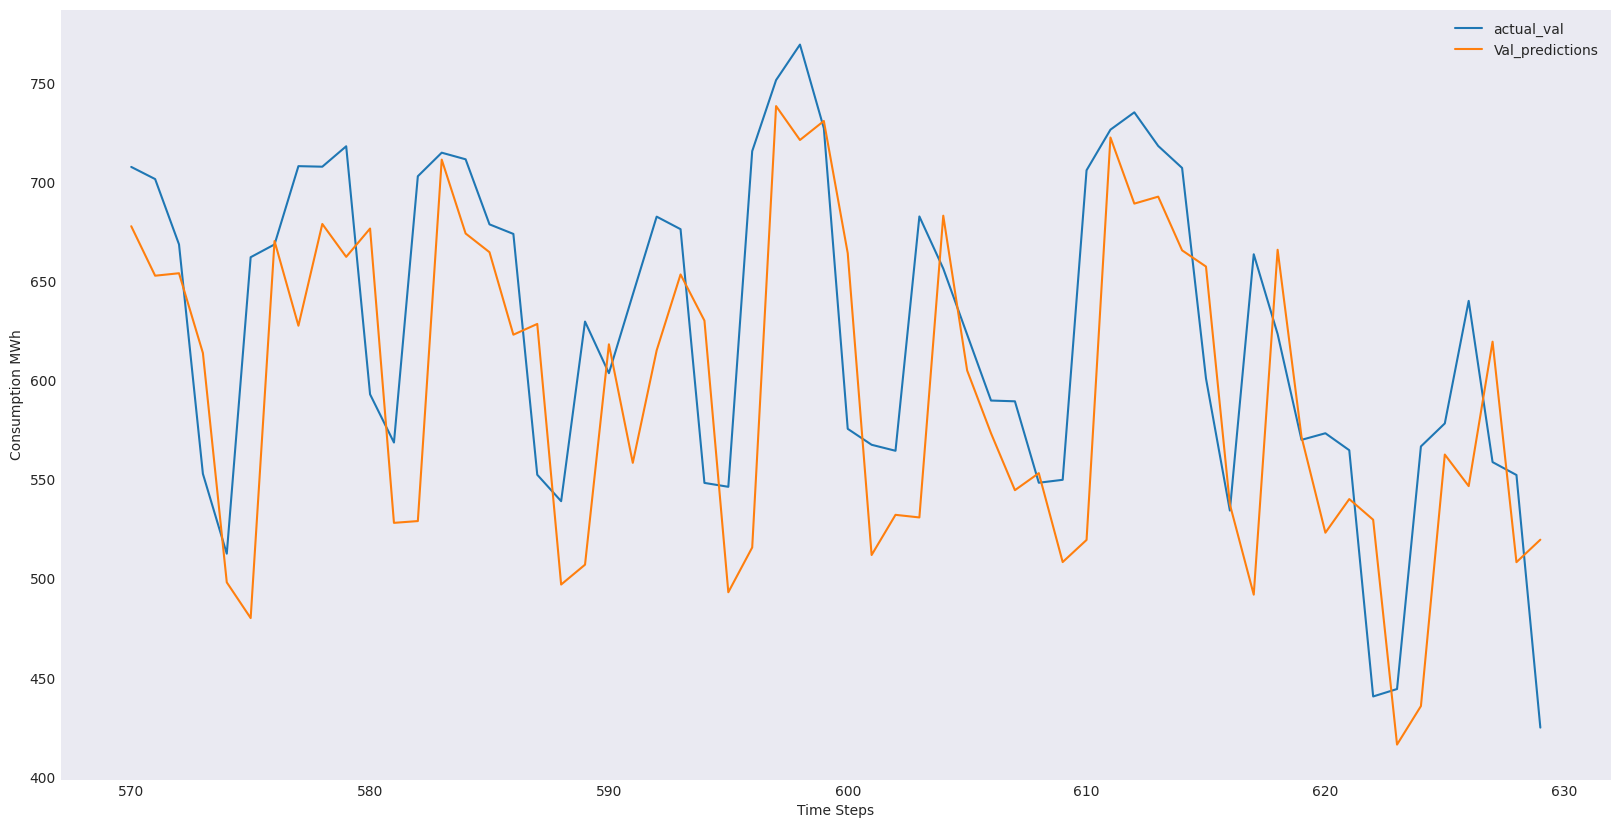

In [31]:
plt.figure(figsize=(20,10))

# Actual Consumption
ActualPlot = np.empty_like(y)
ActualPlot[:, :] = np.nan
ActualPlot[570:, :] = actual_val.tolist()
plt.plot(ActualPlot)

# Validation Prediction
ValPredictionsPlot = np.empty_like(y)
ValPredictionsPlot[:, :] = np.nan
ValPredictionsPlot[570:, :] = val_predictions.tolist()
plt.plot(ValPredictionsPlot)

plt.legend(['actual_val','Val_predictions'])
plt.xlabel('Time Steps')
plt.ylabel('Consumption MWh')

In [32]:
# Predicting consumption using test data
test_predictions = model.predict(X_test)
test_predictions =scaler.inverse_transform(test_predictions)

ytest = ytest.reshape(ytest.shape[0], 1)
actual_test = scaler.inverse_transform(ytest)

test_results = pd.DataFrame()
test_results["test Predictions"] = test_predictions.tolist()
test_results["Actuals_test"] = actual_test.tolist()

test_results

2/2 [==============================] - 0s 5ms/step


,test Predictions,Actuals_test
0,[545.0278930664062],[582.9735827114429]
1,[545.819091796875],[651.4009943181818]
2,[632.9907836914062],[636.2277228535353]
3,[590.420166015625],[464.42553846153845]
4,[430.0899658203125],[385.31496153846155]
5,[384.4751892089844],[551.5049461538463]
6,[553.9384155273438],[552.1315542929293]
7,[521.2413940429688],[680.1542615384616]
8,[683.6774291992188],[583.6727993589743]
9,[525.249267578125],[376.51060256410256]


Text(0, 0.5, 'Consumption MWh')

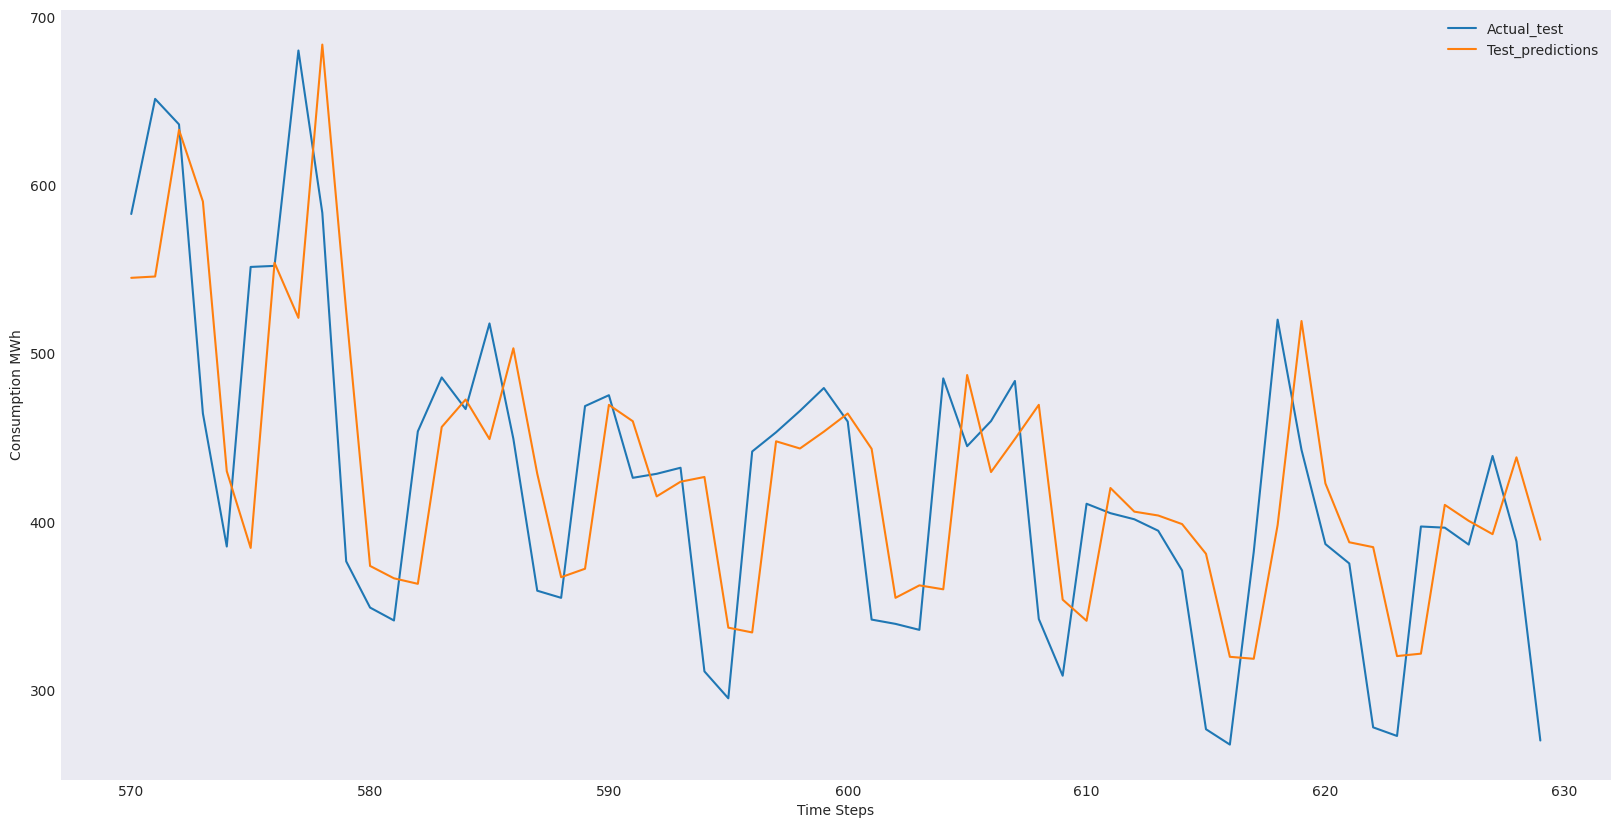

In [33]:
plt.figure(figsize=(20,10))

# Actual Consumption
ActualPlot = np.empty_like(y)
ActualPlot[:, :] = np.nan
ActualPlot[570:, :] = actual_test.tolist()
plt.plot(ActualPlot)

# Test Prediction
TestPredictionsPlot = np.empty_like(y)
TestPredictionsPlot[:, :] = np.nan
TestPredictionsPlot[570:, :] = test_predictions.tolist()
plt.plot(TestPredictionsPlot)

plt.legend(['Actual_test','Test_predictions'])
plt.xlabel('Time Steps')
plt.ylabel('Consumption MWh')

In [34]:
print(len(test_data))
print(test_data[0])
print(len(train_data))
x_input=test_data[337:].reshape(1,-1)
print(x_input.shape)
# print(x_input[0])
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
# print(temp_input)

63
[0.74542373]
504
(1, 0)


In [35]:
# # demonstrate prediction for next 30 days
# from numpy import array

# lst_output=[]
# n_steps=100
# i=0
# test = ""
# while(i<30):
    
#     if(len(temp_input)>100):
#         test = "if"
#         #print(temp_input)
#         x_input=np.array(temp_input[1:])
#         print("{} day input {}".format(i,x_input))
#         x_input=x_input.reshape(1,-1)
#         x_input = x_input.reshape((1, n_steps, 1))
#         #print(x_input)
#         yhat = model.predict(x_input, verbose=0)
#         print("{} day output {}".format(i,yhat))
#         temp_input.extend(yhat[0].tolist())
#         temp_input=temp_input[1:]
#         #print(temp_input)
#         lst_output.extend(yhat.tolist())
#         i=i+1
#     else:
#         test="else"
#         x_input = x_input.reshape((1, n_steps,1))
#         yhat = model.predict(x_input, verbose=0)
#         #print(yhat[0])
#         temp_input.extend(yhat[0].tolist())
#         #print(len(temp_input))
#         lst_output.extend(yhat.tolist())
#         i=i+1

    
# print(test)
# print(len(lst_output))

In [36]:
# print(len(y))
# day_new=np.arange(1,101)
# day_pred=np.arange(101, 131 )
# plt.figure(figsize = (15,10))
# plt.plot(day_new,scaler.inverse_transform(y[2084:]))
# plt.plot(day_pred,scaler.inverse_transform(lst_output))
# print(scaler.inverse_transform(lst_output))

In [37]:
# df3=y.tolist()
# df3.extend(lst_output)
# plt.figure(figsize=(15,10))
# plt.plot(df3[2000:])


In [38]:


model = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
model.add(Bidirectional(LSTM(units = 50, return_sequences = True, input_shape = (time_step, 1))))
model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
model.add(Bidirectional(LSTM(units = 50, return_sequences = True)))
# model.add(Dropout(0.2))

# # Adding a third LSTM layer and some Dropout regularisation
model.add(Bidirectional(LSTM(units = 50, return_sequences = True)))
# model.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
model.add(Bidirectional(LSTM(units = 50)))
# model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mse')

In [39]:
# model.summary()

In [40]:
history = model.fit(X_train, y_train, validation_data = (X_val,yval), verbose = 1,epochs = 60 ,batch_size = 10)


Epoch 1/60
51/51 [==============================] - 17s 59ms/step - loss: 0.0726 - val_loss: 0.0210
Epoch 2/60
51/51 [==============================] - 1s 10ms/step - loss: 0.0208 - val_loss: 0.0232
Epoch 3/60
51/51 [==============================] - 1s 11ms/step - loss: 0.0174 - val_loss: 0.0278
Epoch 4/60
51/51 [==============================] - 1s 11ms/step - loss: 0.0184 - val_loss: 0.0180
Epoch 5/60
51/51 [==============================] - 1s 10ms/step - loss: 0.0165 - val_loss: 0.0359
Epoch 6/60
51/51 [==============================] - 1s 10ms/step - loss: 0.0168 - val_loss: 0.0180
Epoch 7/60
51/51 [==============================] - 1s 11ms/step - loss: 0.0166 - val_loss: 0.0178
Epoch 8/60
51/51 [==============================] - 1s 10ms/step - loss: 0.0161 - val_loss: 0.0177
Epoch 9/60
51/51 [==============================] - 1s 10ms/step - loss: 0.0154 - val_loss: 0.0171
Epoch 10/60
51/51 [==============================] - 1s 11ms/step - loss: 0.0149 - val_loss: 0.0186
Epoch 11

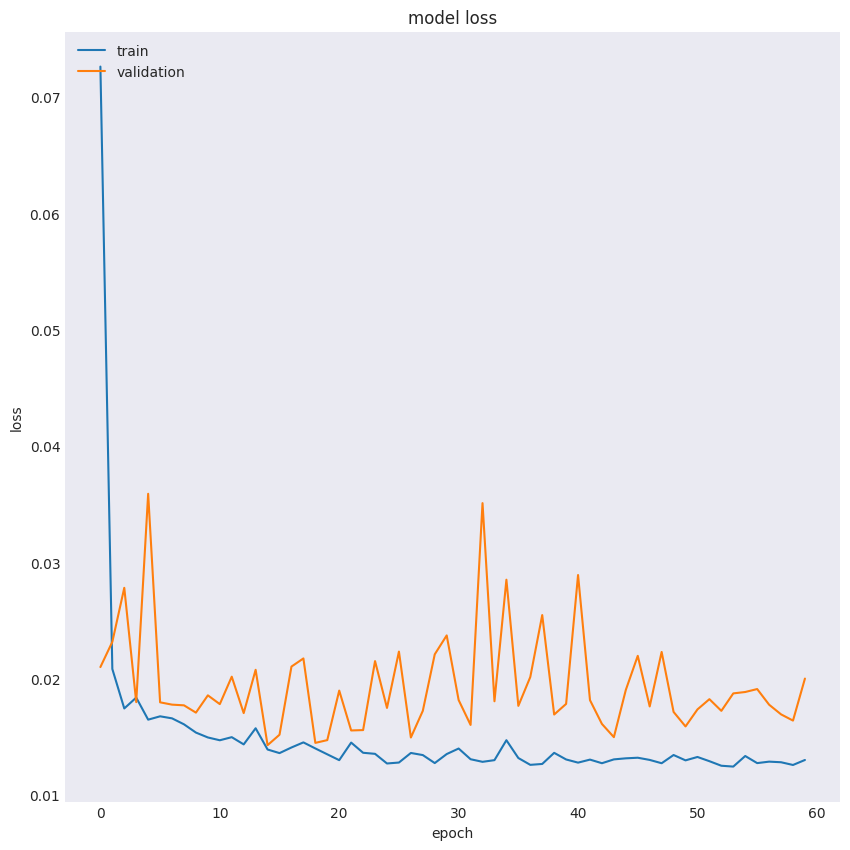

In [41]:
plt.figure(figsize=(10,10))
plt.plot(history.history['loss']) # tb
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [42]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
val_predict=model.predict(X_test)

2/2 [==============================] - 0s 5ms/step


In [43]:
mae = mean_absolute_error(ytest, test_predict)
print('MAE Test Data: '+str(mae))
rmse = np.sqrt(mean_squared_error(ytest, test_predict))
print('RMSE Test Data: '+str(rmse))

mae = mean_absolute_error(y_train, train_predict)
print('MAE Train Data: '+str(mae))
rmse = np.sqrt(mean_squared_error(y_train, train_predict))
print('RMSE Train Data: '+str(rmse))

MAE Test Data: 0.09116324625300222
RMSE Test Data: 0.11898746024066613
MAE Train Data: 0.08728927693693968
RMSE Train Data: 0.11236582985363534


In [44]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)
val_predict=scaler.inverse_transform(val_predict)

In [45]:
print(train_predict.shape)
print(test_predict.shape)
print(val_predict.shape)
print(train_predict[0])
print(y_train.shape)

(501, 1)
(60, 1)
(60, 1)
[395.0139]
(501, 1)


In [46]:
# Predicting consumption using training data
train_predictions = model.predict(X_train)
train_predictions =scaler.inverse_transform(train_predictions)

y_train = y_train.reshape(y_train.shape[0], 1)
actual = scaler.inverse_transform(y_train)
train_results = pd.DataFrame()

train_results["Train Predictions"] = train_predictions.tolist()
train_results["Actuals"] = actual.tolist()

train_results

16/16 [==============================] - 0s 4ms/step


,Train Predictions,Actuals
0,[395.0138854980469],[424.5809221311476]
1,[419.1832580566406],[379.62570286885244]
2,[376.5268859863281],[404.4788579234973]
3,[405.2871398925781],[256.0262233606557]
4,[293.4093017578125],[289.9538859289617]
...,...,...
496,[615.929443359375],[687.0389888059702]
497,[634.4144897460938],[673.7094894278608]
498,[615.6616821289062],[685.6353630050504]
499,[629.639404296875],[687.7965031565654]


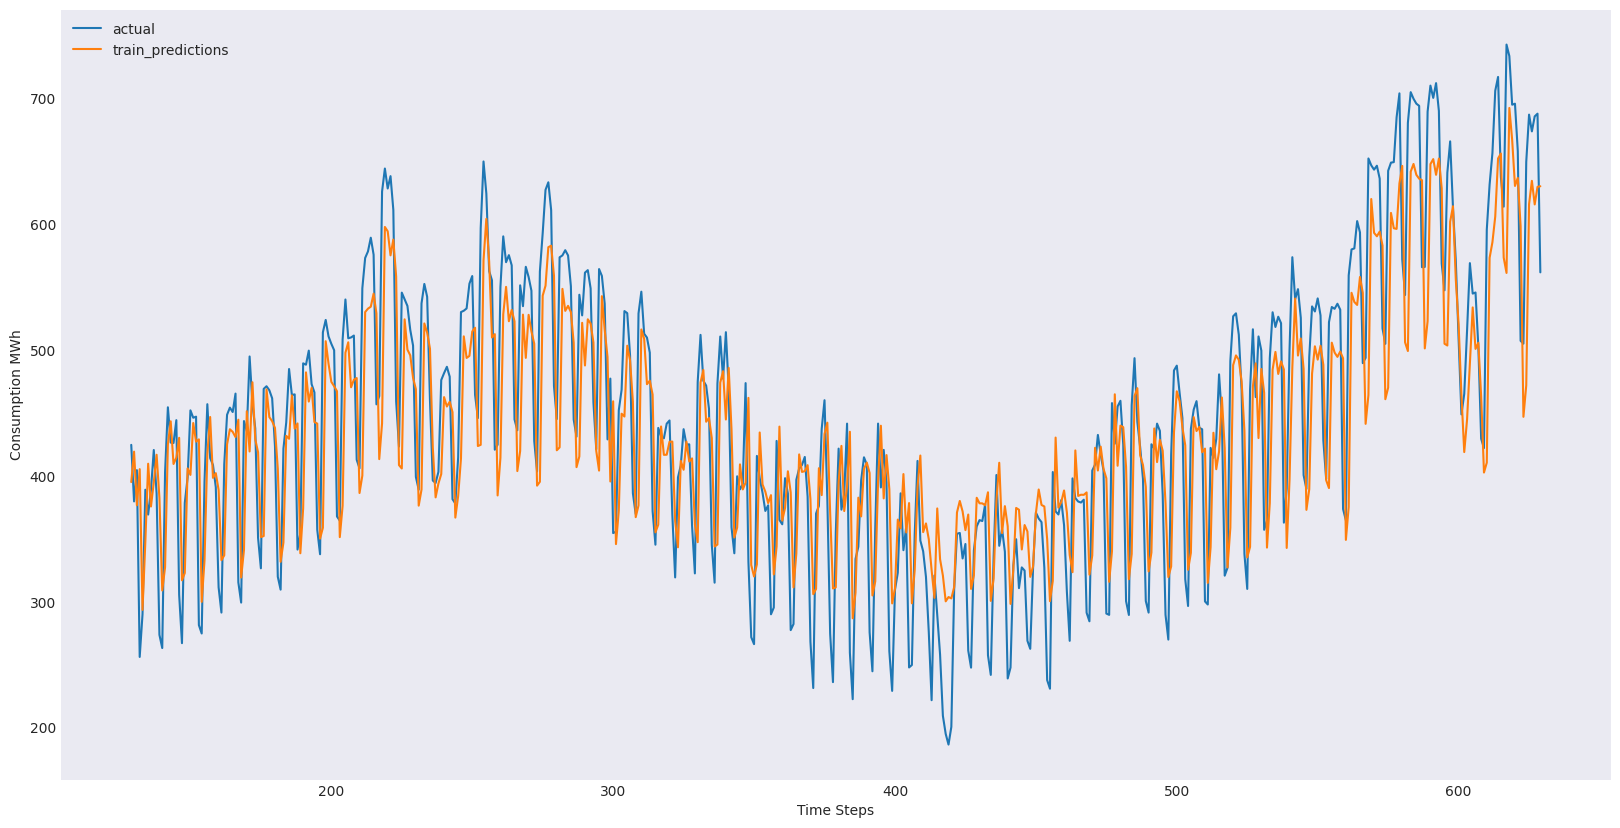

In [47]:
plt.figure(figsize=(20,10))

# Actual Consumption
ActualPlot = np.empty_like(y)
ActualPlot[:, :] = np.nan
ActualPlot[129:, :] = actual.tolist()
plt.plot(ActualPlot)

TrainPredictionsPlot = np.empty_like(y )
TrainPredictionsPlot[:, :] = np.nan
TrainPredictionsPlot[129:, :] = train_predictions.tolist()
plt.plot(TrainPredictionsPlot)

plt.legend(['actual','train_predictions'])
plt.xlabel('Time Steps')
plt.ylabel('Consumption MWh')
plt.show()

In [48]:
# Predicting consumption using validation data
val_predictions = model.predict(X_val)
val_predictions =scaler.inverse_transform(val_predictions)

yval = yval.reshape(yval.shape[0], 1)
actual_val = scaler.inverse_transform(yval)

val_results = pd.DataFrame()
val_results["Val Predictions"] = val_predictions.tolist()
val_results["Actuals_val"] = actual_val.tolist()

val_results

2/2 [==============================] - 0s 4ms/step


,Val Predictions,Actuals_val
0,[664.2379150390625],[707.5575164141414]
1,[643.2275390625],[701.4338794191918]
2,[640.6281127929688],[668.4791007462687]
3,[608.1886596679688],[552.8026094527363]
4,[492.0166015625],[512.4884085820896]
5,[471.2712097167969],[662.0184328358208]
6,[627.3583374023438],[668.4726666666667]
7,[613.9483642578125],[707.9489471393035]
8,[652.4692993164062],[707.6757437810944]
9,[646.7498168945312],[717.973626243781]


Text(0, 0.5, 'Consumption MWh')

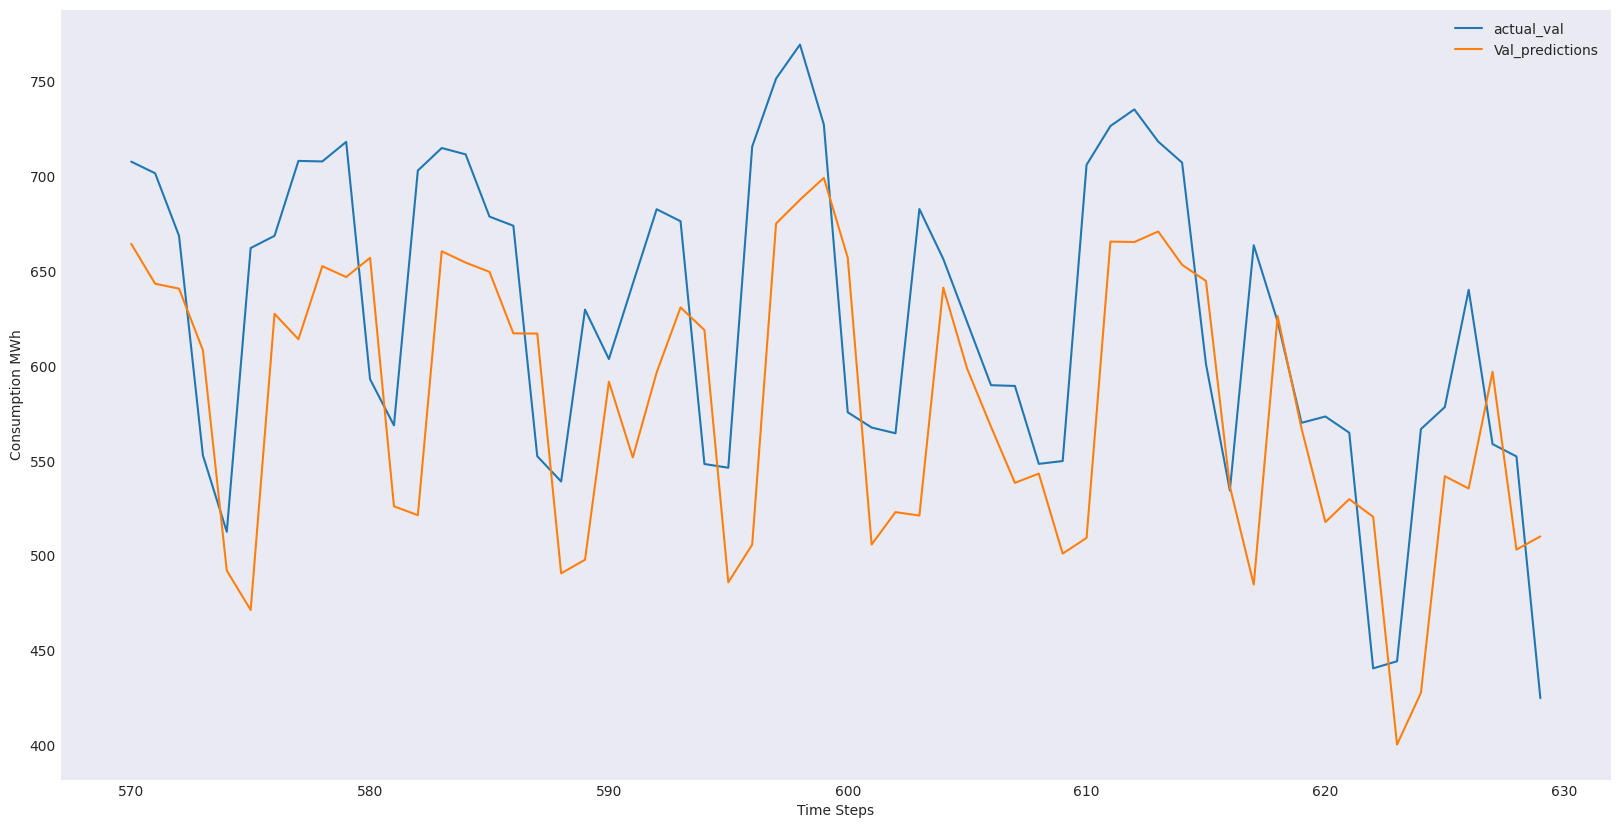

In [49]:
plt.figure(figsize=(20,10))

# Actual Consumption
ActualPlot = np.empty_like(y)
ActualPlot[:, :] = np.nan
ActualPlot[570:, :] = actual_val.tolist()
plt.plot(ActualPlot)

# Validation Prediction
ValPredictionsPlot = np.empty_like(y)
ValPredictionsPlot[:, :] = np.nan
ValPredictionsPlot[570:, :] = val_predictions.tolist()
plt.plot(ValPredictionsPlot)

plt.legend(['actual_val','Val_predictions'])
plt.xlabel('Time Steps')
plt.ylabel('Consumption MWh')

In [50]:
# Predicting consumption using test data
test_predictions = model.predict(X_test)
test_predictions =scaler.inverse_transform(test_predictions)

ytest = ytest.reshape(ytest.shape[0], 1)
actual_test = scaler.inverse_transform(ytest)

test_results = pd.DataFrame()
test_results["test Predictions"] = test_predictions.tolist()
test_results["Actuals_test"] = actual_test.tolist()

test_results

2/2 [==============================] - 0s 5ms/step


,test Predictions,Actuals_test
0,[538.5626220703125],[582.9735827114429]
1,[536.5643920898438],[651.4009943181818]
2,[607.6986083984375],[636.2277228535353]
3,[582.32958984375],[464.42553846153845]
4,[408.622314453125],[385.31496153846155]
5,[372.9342041015625],[551.5049461538463]
6,[535.307373046875],[552.1315542929293]
7,[511.1432189941406],[680.1542615384616]
8,[640.3135375976562],[583.6727993589743]
9,[522.5289306640625],[376.51060256410256]


Text(0, 0.5, 'Consumption MWh')

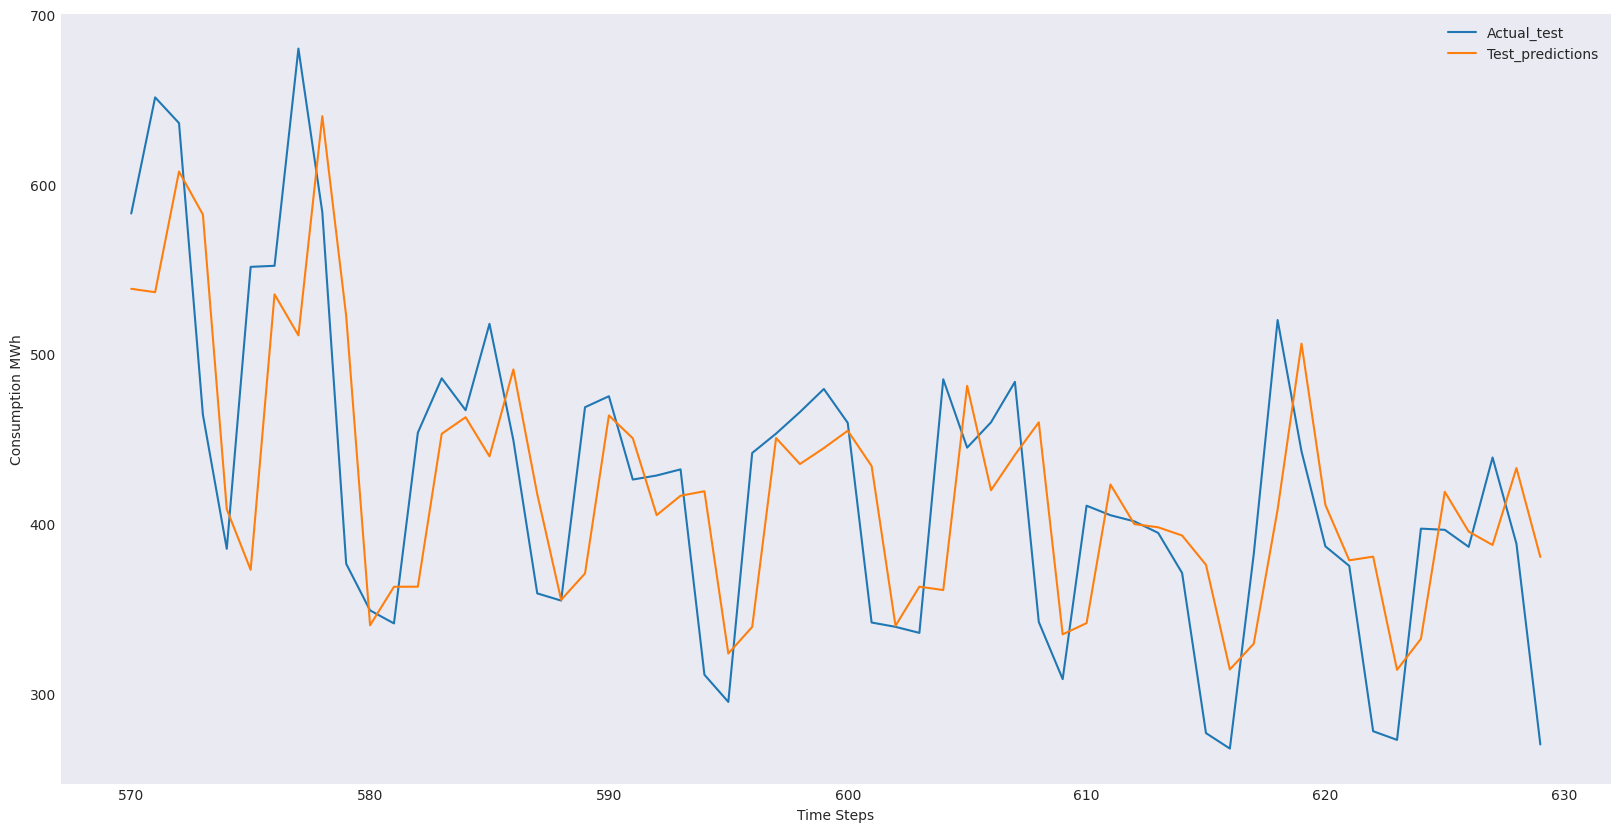

In [51]:
plt.figure(figsize=(20,10))

# Actual Consumption
ActualPlot = np.empty_like(y)
ActualPlot[:, :] = np.nan
ActualPlot[570:, :] = actual_test.tolist()
plt.plot(ActualPlot)

# Test Prediction
TestPredictionsPlot = np.empty_like(y)
TestPredictionsPlot[:, :] = np.nan
TestPredictionsPlot[570:, :] = test_predictions.tolist()
plt.plot(TestPredictionsPlot)

plt.legend(['Actual_test','Test_predictions'])
plt.xlabel('Time Steps')
plt.ylabel('Consumption MWh')

In [52]:
from statsmodels.tsa.arima.model import ARIMA


In [53]:
y = newDataSet.copy().filter(['target'])

In [54]:
train_data, test_data = y[0:int(len(y)*0.9)], y[int(len(y)*0.9):]
model = ARIMA(y, order=(5,1,0), seasonal_order = (1, 1, 1, 12))
model_fit = model.fit()
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                             target   No. Observations:                  630
Model:             ARIMA(5, 1, 0)x(1, 1, [1], 12)   Log Likelihood               -3298.605
Date:                            Fri, 19 Jan 2024   AIC                           6613.210
Time:                                    09:58:19   BIC                           6648.609
Sample:                                09-06-2021   HQIC                          6626.973
                                     - 05-28-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1669      0.033     -5.063      0.000      -0.232      -0.102
ar.L2         -0.5839      0.025   

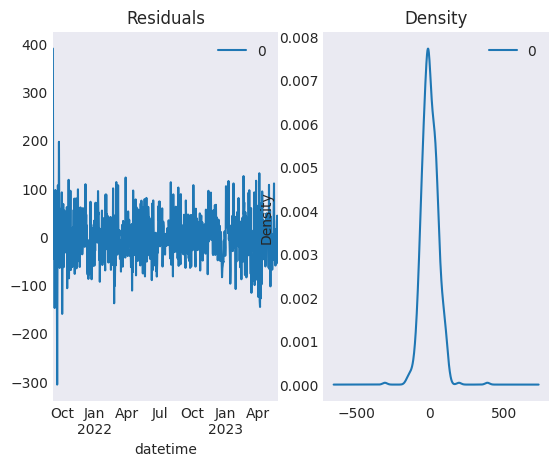

In [55]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [56]:
arima_pred = model_fit.predict(start = len(train_data), end = len(y)-1, typ="levels")


In [57]:
test_data['SARIMA_Predictions'] = arima_pred.copy()

/tmp/ipykernel_42/11370981.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['SARIMA_Predictions'] = arima_pred.copy()


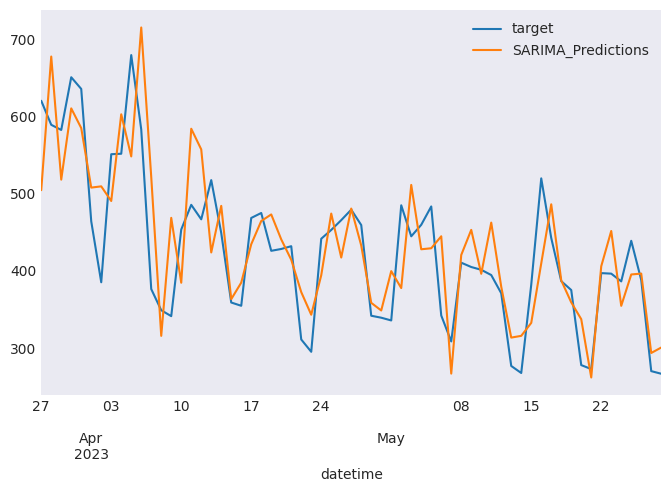

In [58]:
test_data['target'].plot(figsize = (8,5), legend=True)
test_data['SARIMA_Predictions'].plot(legend = True);

In [59]:
mae = mean_absolute_error(test_data['target'], arima_pred)
print('MAE: '+str(mae))
rmse = np.sqrt(mean_squared_error(test_data['target'], arima_pred))
print('RMSE: '+str(rmse))

MAE: 51.199581577452705
RMSE: 63.26340965873921


In [60]:
y = newDataSet.copy().filter(['target'])

In [93]:
train_data, test_data = y[0:int(len(y)*0.9)], y[int(len(y)*0.9):]
model = ARIMA(train_data, order=(5,1,5))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                 target   No. Observations:                  567
Model:                 ARIMA(5, 1, 5)   Log Likelihood               -2837.503
Date:                Fri, 19 Jan 2024   AIC                           5697.005
Time:                        10:29:43   BIC                           5744.730
Sample:                    09-06-2021   HQIC                          5715.632
                         - 03-26-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1740      0.062     -2.805      0.005      -0.296      -0.052
ar.L2         -0.6635      0.050    -13.305      0.000      -0.761      -0.566
ar.L3         -0.6075      0.090     -6.762      0.0

In [94]:
import statsmodels.api as sm

In [95]:
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Defaults
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams.update({'font.size': 12})
plt.style.use('ggplot')

In [96]:
# # Define the d and q parameters to take any value between 0 and 1
# q = d = range(0, 2)
# # Define the p parameters to take any value between 0 and 3
# p = range(0, 4)

# # Generate all different combinations of p, q and q triplets
# pdq = list(itertools.product(p, d, q))

# # Generate all different combinations of seasonal p, q and q triplets
# seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [97]:
# warnings.filterwarnings("ignore") # specify to ignore warning messages

# AIC = []
# SARIMAX_model = []
# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod = sm.tsa.statespace.SARIMAX(train_data,
#                                             order=param,
#                                             seasonal_order=param_seasonal,
#                                             enforce_stationarity=False,
#                                             enforce_invertibility=False)

#             results = mod.fit()

#             print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
#             AIC.append(results.aic)
#             SARIMAX_model.append([param, param_seasonal])
#         except:
#             continue

In [98]:
# mod = sm.tsa.statespace.SARIMAX(train_data,
#                                 order=SARIMAX_model[AIC.index(min(AIC))][0],
#                                 seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],
#                                 enforce_stationarity=False,
#                                 enforce_invertibility=False)

# results = mod.fit()

In [99]:
# residuals = pd.DataFrame(model_fit.resid)
# fig, ax = plt.subplots(1,2)
# residuals.plot(title="Residuals", ax=ax[0])
# residuals.plot(kind='kde', title='Density', ax=ax[1])
# plt.show()

In [100]:
arima_pred = model_fit.predict(start = len(train_data), end = len(y)-1, typ="levels")
arima_pred.shape

(63,)

In [101]:
# pred0 = results.get_prediction(start=len(train_data),end = len(y)-1, dynamic=False)
# pred0_ci = pred0.conf_int()

In [102]:
# pred0_ci

In [103]:
arima_pred

2023-03-27    564.147753
2023-03-28    599.588119
2023-03-29    564.230180
2023-03-30    583.821884
2023-03-31    548.506636
                 ...    
2023-05-24    564.886049
2023-05-25    581.347224
2023-05-26    548.824073
2023-05-27    445.596594
2023-05-28    451.859228
Freq: D, Name: predicted_mean, Length: 63, dtype: float64

In [104]:
test_data['ARIMA_Predictions'] = arima_pred.copy()

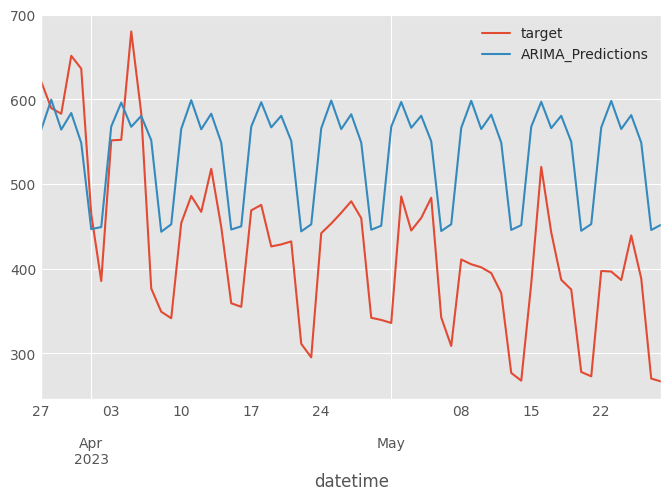

In [105]:
test_data['target'].plot(figsize = (8,5), legend=True)
test_data['ARIMA_Predictions'].plot(legend = True);

In [106]:
mae = mean_absolute_error(test_data['target'], arima_pred)
print('MAE: '+str(mae))
rmse = np.sqrt(mean_squared_error(test_data['target'], arima_pred))
print('RMSE: '+str(rmse))

MAE: 122.01393751498345
RMSE: 132.66298389045042
